In [ ]:
!pip install matplotlib|

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
classes = os.listdir('./Train')
img_path = []
for one in classes:
    tmp_path = os.listdir(os.path.join('./Train',one))
    img_path += [os.path.join('./Train',one,one_) for one_ in tmp_path] 

In [4]:
from PIL import Image

In [5]:
train_x = np.zeros((len(img_path),64, 64, 3))

In [6]:
for i in range(0,len(img_path)):
    train_x[i,:,:,:]=np.asarray(Image.open(img_path[i]).resize((64,64)))

In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [8]:
class Dataset(Dataset):
    def __init__(self,x_data):
        self.x_data = x_data
    def __len__(self): 
        return len(self.x_data)
    def __getitem__(self, idx): 
        x = torch.FloatTensor(self.x_data[idx])
        return x

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [10]:
dataset = Dataset(train_x)

In [11]:
import torch.nn as nn

In [12]:
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
train_dl = DataLoader(train_x,16, shuffle=True,num_workers=3, pin_memory=True)

In [13]:
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main =nn.Sequential(
        nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),
        # state size. (ngf*8) x 4 x 4
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),
        # state size. (ngf*4) x 8 x 8
        nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),
        # state size. (ngf*2) x 16 x 16
        nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        # state size. (ngf) x 32 x 32
        nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)
    def model(self):
        return self.main

In [14]:
G = Generator()

In [15]:
check = G.model()(torch.randn(1,100,1,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


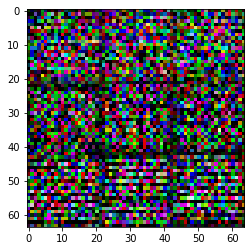

In [16]:
plt.imshow(check.reshape(1,64,64,3).detach().numpy()[0])

In [17]:
check.shape

torch.Size([1, 3, 64, 64])

In [18]:
criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [19]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(16,100,1,1).to(device)
    fake_images = G(z)
    labels = torch.ones(16, 1).to(device)
    g_loss = criterion(D(fake_images), labels)


    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [20]:
sample_vectors = torch.randn(16,100,1,1).to(device)
from torchvision.utils import save_image

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(fake_images, os.path.join('./', fake_fname), nrow=4)
    


In [21]:
# Before training
save_fake_images(0)

Saving fake_images-0000.png


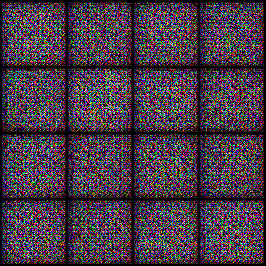

In [22]:
Image.open(os.path.join('./', 'fake_images-0000.png'))

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [24]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(16, 1).to(device)
    fake_labels = torch.zeros(16, 1).to(device)
        
    # Loss for real images
    outputs = D.forward(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(16, 100,1,1).to(device)
    fake_images = G.model()(z)
    outputs = D.forward(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [25]:
criterion = nn.BCELoss()
D = Discriminator()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [ ]:
num_epochs = 900
total_step = len(train_dl)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []


for epoch in range(num_epochs):
    for i, images  in enumerate(train_dl):
        # Load a batch & transform to vectors
        images = images.reshape(16,3,64,64).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images.float())
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 100 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/900], Step [100/625], d_loss: 0.0727, g_loss: 9.1250, D(x): 1.00, D(G(z)): 0.07
Epoch [0/900], Step [200/625], d_loss: 0.0009, g_loss: 8.7569, D(x): 1.00, D(G(z)): 0.00
Epoch [0/900], Step [300/625], d_loss: 0.0040, g_loss: 8.1020, D(x): 1.00, D(G(z)): 0.00
Epoch [0/900], Step [400/625], d_loss: 0.0003, g_loss: 7.9507, D(x): 1.00, D(G(z)): 0.00
Epoch [0/900], Step [500/625], d_loss: 0.0190, g_loss: 10.4294, D(x): 1.00, D(G(z)): 0.02
Epoch [0/900], Step [600/625], d_loss: 0.0285, g_loss: 8.4687, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/900], Step [100/625], d_loss: 0.0356, g_loss: 16.4593, D(x): 0.97, D(G(z)): 0.00
Epoch [1/900], Step [200/625], d_loss: 0.0212, g_loss: 8.4004, D(x): 0.98, D(G(z)): 0.00
Epoch [1/900], Step [300/625], d_loss: 0.0043, g_loss: 8.3175, D(x): 1.00, D(G(z)): 0.00
Epoch [1/900], Step [400/625], d_loss: 0.0015, g_loss: 7.7046, D(x): 1.00, D(G(z)): 0.00
Epoch [1/900], Step [500/625], d_loss: 0.0094, g_loss: 7.2998, D(x): 1.00, D(G(z

In [ ]:
images/255

In [ ]:
outputs.shape